In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import dask_distance as ddist

from dask.distributed import Client
from dask import delayed
from scipy.spatial import distance

from tqdm import tqdm_notebook as tqdm

from multiprocessing import Pool

from simulated_annealing import *

In [4]:
#client = Client()

In [5]:
#client

In [6]:
#client.close()

In [7]:
cities = pd.read_csv("cities.csv", index_col=0)

In [8]:
cities_small = cities.iloc[:10000]

In [9]:
cities_arr = cities.values
n_cities = cities_arr.shape[0]

# Calculate distances between points

In [76]:
#@delayed
def calculate_distance(a):
    idx1 = a
    idx2 = np.arange(a, n_cities)
    out = ((cities_arr[idx1] - cities_arr[idx2])**2).sum(axis=1)
    return np.pad(out, (a, 0), mode='constant', constant_values=(0,0))

In [77]:
distances = []
def get_pair(n):
    for i in range(n):
        for j in range(i+1, n_cities):
            yield (i, j)

In [79]:
%%time
pool = Pool(processes=4) 
out = pool.map(calculate_distance, range(1000))

CPU times: user 1.62 s, sys: 3.93 s, total: 5.55 s
Wall time: 6.47 s


In [38]:
distances = []
for pair in all_pairs:
    distances.append(calculate_distance(pair))

In [19]:
(cities.shape[0] ** 2)/(5000 ** 2) / 60

26.075051574

In [84]:
npz = np.load('data_vect_30000.npy.npz', )

In [ ]:
arr_int = (npz.get('arr_0') / 1000).astype('uint16')

In [ ]:
arr_int.nbytes/(1024 * 1024 * 1024)

That was 14Gb even if we round to int. And still 6Gb after reducing resolution by a lot. And that's just for one file out of 20.
Oof! New method...

# Pairwise distances

In [76]:
pairwise = distance.cdist(cities_small, cities_small)

In [77]:
def fitness(solution):
    total_fitness = 0
    for i in range(n_cities - 1):
        loc1 = solution[i]
        loc2 = solution[i+1]
        total_fitness += pairwise[loc1, loc2]
    
    final_stop = solution[-1]
    start = solution[0]
    total_fitness += pairwise[final_stop, start]
    
    return total_fitness

In [94]:
def propose(solution, n_opt = 2):
    
    swap1, swap2 = np.random.choice(np.arange(1, len(solution)), size=2, replace=False)
    new_solution = solution.copy()
    new_solution[swap1], new_solution[swap2] = new_solution[swap2], new_solution[swap1]
    
    return new_solution

In [183]:
def plot_solution(solution, cities, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    x = cities.values[solution][:, 0]
    y = cities.values[solution][:, 1]
    
    ax.plot(x, y)
    
    return ax

In [14]:
def score_solution(ordered_trip, city_ids=None, apply_penalty=True):
    n_cities = ordered_trip.shape[0]
    penalty = 1.0
    score = 0
    for from_ in range(n_cities - 1):
        to_ = from_ + 1
        score += distance.euclidean(ordered_trip[from_], ordered_trip[to_]) * penalty
        if apply_penalty:
            if ((from_ % 10) == 0) and not is_prime(city_ids[from_]):
                penalty = 1.1
            else:
                penalty = 1.0
        
    # add return
    score += distance.euclidean(ordered_trip[from_], ordered_trip[to_]) * penalty
    
    return score

In [15]:
def score_solution2(ordered_trip, city_ids=None, apply_penalty=True):
    n_cities = ordered_trip.shape[0]
    penalty = 1.0
    score = 0
    for from_ in range(n_cities - 1):
        to_ = from_ + 1
        if apply_penalty:
            if ((to_ % 10) == 0) and not is_prime(city_ids[from_]):
                penalty = 1.1
            else:
                penalty = 1.0
        score += distance.euclidean(ordered_trip[from_], ordered_trip[to_]) * penalty
    # add return
    score += distance.euclidean(ordered_trip[from_], ordered_trip[to_]) * penalty
    
    return score

In [72]:
score_solution(cities_ordered, route, apply_penalty=True)

1516785.4549612468

In [55]:
score_solution(cities_ordered, route, apply_penalty=False)

1503081.9998551556

In [68]:
def write_solution(route, filename='route_LKJ'):
    
    route_df = pd.DataFrame(route, columns=['Path'])
    route_df.loc[197769] = 0
    route_df.to_csv("./{}.csv".format(filename), index=False)

In [69]:
write_solution(route)

# LKH 2.0

In [9]:
!head tsp_solution.csv

NAME : traveling-santa-2018-prime-paths.1503080129.tour
COMMENT : Length = 1503080129
COMMENT : Found by LKH [Keld Helsgaun] Sat Aug 17 22:41:40 2019
TYPE : TOUR
DIMENSION : 197769
TOUR_SECTION
1
47240
29923
42252


In [10]:
route = pd.read_csv("tsp_solution.csv", skiprows=5, skipfooter=2).values.squeeze()
route = route -1

/Users/Sid_Ravinutala/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [11]:
cities_ordered = cities_arr[route]
cities_ordered[:,0]

array([316.83673906, 314.74799975, 320.12911173, ..., 305.18604794,
       306.73326725, 314.7160068 ])

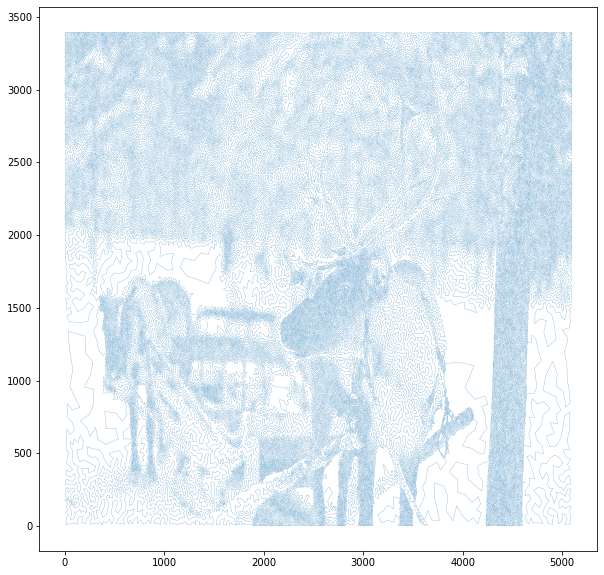

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot(cities_ordered[:,0], cities_ordered[:,1], lw=0.2)

# Clustering and then solving within cluster

In [112]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from cycler import cycler

import seaborn as sns

In [113]:
n_clusters = 300
clusterer = MiniBatchKMeans(n_clusters = n_clusters, batch_size=10000)
clusterer.fit(cities_arr)

MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=300, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [114]:
ids = clusterer.predict(cities_arr)
cluster_centers = clusterer.cluster_centers_

In [157]:
starting_cluster = clusterer.labels_[0]

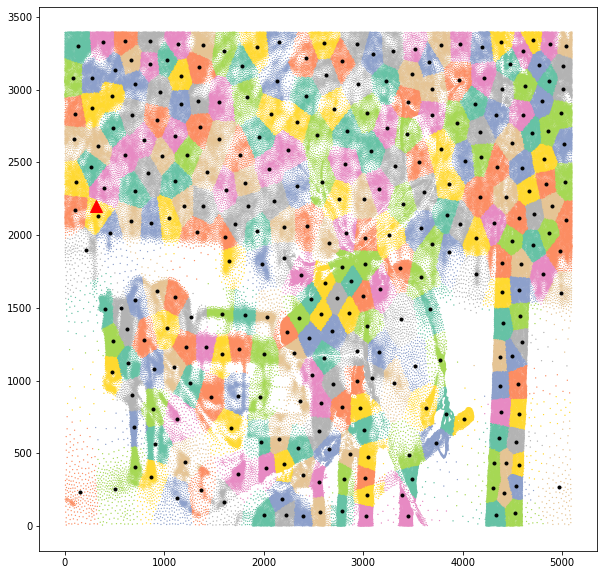

In [116]:
f, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x=cities_arr[:,0], y=cities_arr[:,1], hue=ids[:], s=0.3, 
                edgecolor=None, palette='Set2', legend=None)
plt.plot(cluster_centers[:, 0], cluster_centers[:, 1], ".k")
plt.plot(cities_arr[0, 0], cities_arr[0, 1], "^r", ms=12)

In [13]:
distances = distance.squareform(distance.pdist(cluster_centers))

## Anneal the cluster centers

In [148]:
order_idx, cluster_order = run_simulated_annealing(cluster_centers, restarts=5, fix_start=None, fix_end=None)

CLUSTER , RESTART 0: 669789.7782077369
    >>> 666166.9523806042
    >>> 354680.64088813105
    >>> 222531.81504474895
    >>> 157818.10500408243
    >>> 105454.71861978907
CLUSTER , RESTART 1: 74568.53797099183
    >>> 79349.92355343091
    >>> 79459.57268904951
    >>> 82284.18480365147
    >>> 82496.82033097412
    >>> 77423.56997443372
CLUSTER , RESTART 2: 70324.28383508479
    >>> 73268.12496246306
    >>> 81013.80751711657
    >>> 75532.26625568079
    >>> 75440.81769237462
    >>> 79341.92316724392
CLUSTER , RESTART 3: 69771.97274406887
    >>> 70151.27071353166
    >>> 77227.9736002491
    >>> 71369.95769246705
    >>> 75601.59019142987
    >>> 77630.86556043799
CLUSTER , RESTART 4: 69740.3919471529
    >>> 76370.45531757461
    >>> 73311.66744731889
    >>> 74427.32649990739
    >>> 69740.3919471529
    >>> 72275.78893180843


Need to roll till the cluster with city 0 is at the start. This is important when calculating the primes.

In [159]:
roll_count = np.argwhere(order_idx == starting_cluster)[0][0]

order_idx2 = np.roll(order_idx, roll_count)
cluster_order = np.roll(cluster_order, roll_count, axis=0)

In [160]:
ordered_cc = cluster_centers[order_idx2]

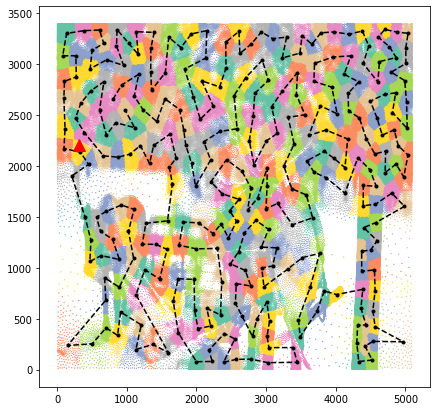

In [163]:
f, ax = plt.subplots(figsize=(7, 7))
#plot_solution(X_best, cluster_centers)
sns.scatterplot(x=cities_arr[:,0], y=cities_arr[:,1], hue=ids[:], s=0.3, 
                edgecolor=None, palette='Set2', legend=None, ax=ax)
ax.plot(ordered_cc[:, 0], ordered_cc[:, 1], ".--k")
ax.plot(cities_arr[0, 0], cities_arr[0, 1], "^r", ms=12)

plt.savefig("./images/connect_clusters.png", dpi=200)

In [216]:
np.save("./cluster_order.npy", order_idx)b

In [134]:
co = np.load("./cluster_order.npy")

In [219]:
np.save("./cluster_labels.npy", clusterer.labels_)

In [293]:
clusterer.labels_.nbytes

791076

## Smooth cluster

In [164]:
smooth_route = []
smooth_route_ids = []
for i in range(n_clusters - 1):
    # What is the closest point between this and the next cluster?
    a = cities_arr[clusterer.labels_ == order_idx[i]]
    b = cities_arr[clusterer.labels_ == order_idx[i+1]]
    
    A = distance.cdist(a, b)
    
    a_min, b_min = np.unravel_index(A.argmin(), A.shape) 
    smooth_route += [a[a_min], b[b_min]]
    smooth_route_ids += [a_min, b_min]
    
a = cities_arr[clusterer.labels_ == order_idx[-1]]
b = cities_arr[clusterer.labels_ == order_idx[0]]
A = distance.cdist(a, b)
a_min, b_min = np.unravel_index(A.argmin(), A.shape) 
smooth_route = [b[b_min]] + smooth_route + [a[a_min]]
smooth_route_ids = [b_min] + smooth_route_ids + [a_min]

smooth_points = np.vstack(smooth_route)
smooth_points_id = np.vstack(smooth_route_ids).squeeze()

In [165]:
smooth_points = np.vstack(smooth_route)
smooth_points_id = np.vstack(smooth_route_ids).squeeze()

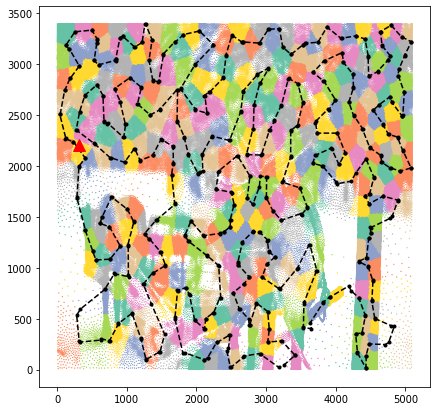

In [167]:
f, ax = plt.subplots(figsize=(7, 7))
#plot_solution(X_best, cluster_centers)
sns.scatterplot(x=cities_arr[:,0], y=cities_arr[:,1], hue=ids[:], s=0.3, 
                edgecolor=None, palette='Set2', legend=None, ax=ax)
ax.plot(smooth_points[:, 0], smooth_points[:, 1], ".--k")
ax.plot(cities_arr[0, 0], cities_arr[0, 1], "^r", ms=12)

plt.savefig("./images/smooth_connect_clusters.png", dpi=200)

## Within cluster 

In [278]:
(clusterer.labels_ == order_idx[0]).sum()

627

In [281]:
def calculate_offsets(order_idx):
    offset = 0
    all_offset = []
    for segment in range(order_idx.shape[0]):
        all_offset.append(offset)
        n_in_cluster = (clusterer.labels_ == order_idx[segment]).sum()
        offset = (offset + n_in_cluster) % 10
    
    return all_offset

In [283]:
offsets = calculate_offsets(order_idx)

In [ ]:
all_clusters = []
for label in tqdm(range(5)):

    cluster_cities = (clusterer.labels_ == order_idx[label])
    cluster = cities_arr[cluster_cities]
    fixed_start=smooth_points_id[2*label]
    fixed_end =smooth_points_id[2*label + 1]
    
    n_cluster_points = cluster_cities.shape[0]
    
    point_order_idx, point_order = run_simulated_annealing(cluster, restarts=1, city_labels = np.argwhere(cluster_cities),
                                                           fix_start=fixed_start, fix_end=fixed_end, offset=offsets[label], label=label)
    
    all_clusters.append(point_order)
    

In [223]:
def get_cluster_paths(label):
    
    cluster = cities_arr[clusterer.labels_ == order_idx[label]]
    fixed_start=smooth_points_id[2*label]
    fixed_end =smooth_points_id[2*label + 1]

    point_order_idx, point_order = run_simulated_annealing(cluster, restarts=5, city_labels=fix_start=fixed_start, 
                                                           fix_end=fixed_end, label=label)
    
    np.save("cluster_{}.npy".format(label), point_order)
    
    return point_order

In [ ]:
pool = Pool(4)
all_paths = pool.map(get_cluster_paths, range(n_clusters))

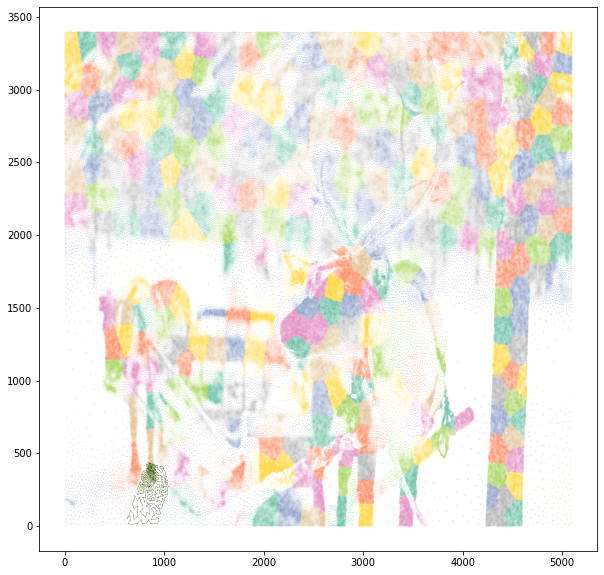

In [211]:
f, ax = plt.subplots(figsize=(10, 10))
#plot_solution(X_best, cluster_centers)
sns.scatterplot(x=cities_arr[:,0], y=cities_arr[:,1], hue=ids[:], s=0.3, alpha=0.3,
                edgecolor=None, palette='Set2', legend=None, ax=ax)
ax.plot(point_order[:, 0], point_order[:, 1], "-k", lw=0.2, )
ax.plot(cities_arr[0, 0], cities_arr[0, 1], "^r", ms=12)

## Combine within clusters

In [42]:
cluster_order = np.load("./penalized_solution_5.600//cluster_order.npy")
all_arr = []
for i in range(300):
    try:
        arr = np.load("./penalized_solution_5.600/cluster_{}.npy".format(i))
    except:
        print("Cluster not found:", i)
    all_arr.append(arr)

Cluster not found: 66
Cluster not found: 67
Cluster not found: 68


In [37]:
cluster_labels = np.load("./penalized_solution_5.600/cluster_labels.npy")

In [38]:
solution_pen = np.vstack(all_arr)

In [39]:
score_solution2(solution_pen, city_ids=None, apply_penalty=False)

1781647.264396744

In [43]:
(1781647.264396744 - 1513747)*100/1513747

17.697822978129373

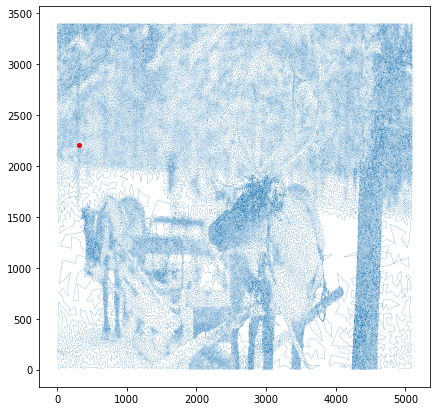

In [40]:
f, ax = plt.subplots(figsize=(7, 7))
#plot_solution(X_best, cluster_centers)
#sns.scatterplot(x=cities_arr[:,0], y=cities_arr[:,1], hue=cluster_labels[:], s=0.3, alpha=0.3,
#                edgecolor=None, palette='Set2', legend=None, ax=ax)
ax.plot(solution_pen[:, 0], solution_pen[:, 1], "-", lw=0.2, )
ax.plot(cities_arr[0, 0], cities_arr[0, 1], ".r", ms=8)

plt.savefig("images/sim_anneal_result.png", dpi=200)

## DEAP the cluster centers

In [160]:
from deap import creator, tools, algorithms, base, cma
import array
import random
import numpy

In [157]:
distance_map = distances
IND_SIZE = distances.shape[0]

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("300", random.sample, range(IND_SIZE), IND_SIZE)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalTSP(individual):
    distance = distance_map[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += distance_map[gene1][gene2]
    return distance,

toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalTSP)

def main():
    random.seed(169)

    pop = toolbox.population(n=300)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 500, stats=stats, 
                        halloffame=hof, verbose=False)
    
    return pop, stats, hof

In [158]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", benchmarks.rastrigin)

def main():
    numpy.random.seed(128)

    strategy = cma.Strategy(centroid=[5.0]*N, sigma=5.0, lambda_=20*N)
    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
   
    algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof)
    
    

CPU times: user 3min 48s, sys: 1.19 s, total: 3min 49s
Wall time: 3min 50s


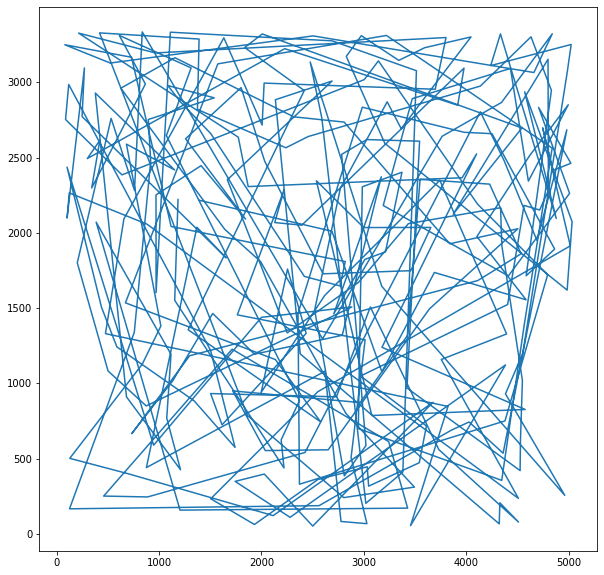

In [159]:
a = pop[0]
a.tolist()

plot_solution(a.tolist(), cluster_centers)